# AG2 - Actividad Guiada 2

Nombre: Carlos Javier Bravo Intriago

https://colab.research.google.com/drive/1Nuj5Gf1vmRnA6Lg4XHXRs-Fx62q9rHlq?usp=sharing

https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025/tree/main/AG2




In [ ]:
import math
import copy
import time
import random
import decimal
import tracemalloc
from functools import wraps
from collections import defaultdict
from typing import List, Union, Tuple, Dict, Optional


inf = float('inf')
NumericType = Union[float, int, decimal.Decimal]
FaresType = List[List[NumericType]]
PricesType = List[List[NumericType]]
PathsType = List[List[NumericType]]


# Decorador medidor de tiempo
def measure_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.monotonic()
        result = func(*args, **kwargs)
        end_time = time.monotonic()
        elapsed_time = end_time - start_time
        if isinstance(result, tuple) and len(result) == 2 and isinstance(result[1], dict):
            result[1]["time"] = elapsed_time
            return result
        else:
            return result, {"time": elapsed_time}
    return wrapper


# Decorador medidor de Memoria
def measure_memory(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        result = func(*args, **kwargs)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        # 1 << 10 = 1024, 1 << (10*2) = 1024**2  Conversion a MB
        peak = peak / (1 << (10 * 2))
        if isinstance(result, tuple) and len(result) == 2 and isinstance(result[1], dict):
            result[1]["memory"] = peak
            return result
        else:
            return result, {"memory": peak}

    return wrapper


def print_matrix(
        matrix: PathsType,
        title: Optional[str] = None,
        width: int = 6,
        enable_headers: bool = True,
        header_row_char: str = "",
        header_col_char: str = "",

) -> None:
    if len(header_row_char)>1:
        header_row_char = header_row_char[0]
    if len(header_col_char)>1:
        header_col_char = header_col_char[0]
    if title:
        print(f"{title:^{len(matrix) * width + (5 if enable_headers else 0)}}")
        if enable_headers:
            print("-" * 5, end="")
        print("-" * (len(matrix) * width))
    if enable_headers:
        print(" " * 5, end="")
        for j in range(len(matrix)):
            h = f"{header_col_char}{j}"
            print(f"{h:>{width}}", end="")
        print()
        print("    " + "-" * (len(matrix) * width + 1))
    for i, row in enumerate(matrix):
        if enable_headers:
            h = f"{header_row_char}{i}"
            print(f"{h:>{3}} |", end="")
        row_fmt = [
            f"{str(val).replace('inf', '∞'):>{width}}"
            for val in row
        ]
        print("".join(row_fmt))
    if title:
        if enable_headers:
            print("-" * 5, end="")
        print("-" * (len(matrix) * width))
    print()

# método para generar las matrices de tarea/agente aleatorias
def generate_random_task_list(n: int, start: int = 1, stop: int = 100, seed: Optional[int] = None) -> List[List[int]]:
    if seed is not None:
        random.seed(seed)
    return [[random.randrange(start, stop) for _ in range(n)] for _ in range(n)]


## 1. Programación Dinámica. Viaje por el río
* **Definición**: Es posible dividir el problema en subproblemas más pequeños, guardando las soluciones para ser utilizadas más adelante.
* **Características** que permiten identificar problemas aplicables:<br>
  -Es posible almacenar soluciones de los subproblemas para ser utilizados más adelante<br>
  -Debe verificar el principio de optimalidad de Bellman: “en una secuencia óptima de decisiones, toda sub-secuencia también es óptima” (*)<br>
  -La necesidad de guardar la información acerca de las soluciones parciales unido a la recursividad provoca la necesidad de preocuparnos por la complejidad espacial (cuantos recursos de espacio usaremos)<br>

### A. Problema<br>
En un río hay `n` embarcaderos y debemos desplazarnos río abajo desde un embarcadero a otro. Cada embarcadero tiene precios diferentes para ir de un embarcadero a otro situado más abajo. Para ir del embarcadero i al j, puede ocurrir que sea más barato hacer un trasbordo por un embarcadero intermedio k. El problema consiste en determinar la combinación más barata.

<div style="flex: 0 0 100px; text-align: center;">
        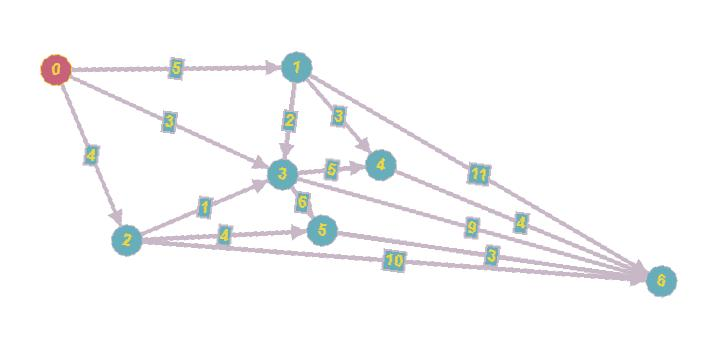
        <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 1. Problema del viaje por el río.</p>
    </div>
</div>



* Consideramos una tabla TARIFAS(i,j) para almacenar todos los precios que
nos ofrecen los embarcaderos.<br>
* Si no es posible ir desde i a j daremos un valor alto para garantizar que
ese trayecto no se va a elegir en la ruta óptima(modelado habitual para restricciones)

In [ ]:
#Viaje por el río - Programación dinámica

TARIFAS = [
    #   0    1    2    3    4    5    6
    [   0,   5,   4,   3, inf, inf, inf],  # 0
    [ inf,   0, inf,   2,   3, inf,  11],  # 1
    [ inf, inf,   0,   1, inf,   4,  10],  # 2
    [ inf, inf, inf,   0,   5,   6,   9],  # 3
    [ inf, inf, inf, inf,   0, inf,   4],  # 4
    [ inf, inf, inf, inf, inf,   0,   3],  # 5
    [ inf, inf, inf, inf, inf, inf,   0]   # 6
]

print_matrix(TARIFAS, title="Tarifas")

In [ ]:
@measure_time
@measure_memory
def precios(tarifas: FaresType) -> Tuple[PricesType, PathsType]:
    """
    - Autor: Mónica Sánchez Cuberes (Con ayuda de Claude de Anthropic). Corrección sugerida en el Foro
    - Modificado por: Carlos Javier Bravo Intriago
    - Fecha: Enero 2026
    -----------------------

    Cálculo de la matriz de PRECIOS y RUTAS\n
    Precios - contiene la matriz del mejor precio para ir de un nodo a otro\n
    Rutas - contiene los nodos intermedios para ir de un nodo a otro

    Este código se basa en el algoritmo de Floyd-Warshall, el cual fue
    sugerencia propuesta por Mónica Sánchez Cuberes como parte de una
    corrección sugerida en el Foro. Las salidas de las tuplas obedecen a la
    forma canónica de D (Matriz Distancias o pesos), y Π (Matriz de
    predecesores)

    Complejidad temporal O(N³)

    Cambios:
    -----------------------
    * [1] Se agregaron validaciones para evitar recorrer el bucle si no existe
      conexión
    * [2] Se omite que se rellene con valores de `i` por debajo de la diagonal
      principal si no existe conexión alguna con otro nodo


    ----------------
    :param tarifas: Matriz de tarifas (costos) entre nodos
    :return: Tupla con los arreglos de Precios y Rutas de forma canónica
    """
    n = len(tarifas)

    _precios = [tarifa[:] for tarifa in tarifas]
    rutas = [[i if i != j and tarifas[i][j] != inf else -1 for j in range(n)]
             for i in range(n)]  # [2]
    for k in range(n):
        for i in range(n):
            if _precios[i][k] == inf:  # [1]
                continue
            for j in range(n):
                if _precios[k][j] == inf:  # [1]
                    continue
                if _precios[i][k] + _precios[k][j] < _precios[i][j]:
                    _precios[i][j] = _precios[i][k] + _precios[k][j]
                    rutas[i][j] = rutas[k][j]  # Resultado en forma Canónica
    return _precios, rutas

In [ ]:
PRECIOS, RUTA, estadisticas = precios(TARIFAS)
print(estadisticas)

In [ ]:
print_matrix(PRECIOS, title="Precios")

In [ ]:
print_matrix(RUTA, title="Ruta")

In [ ]:
def calcular_ruta(ruta: PathsType, desde: int, hasta: int) -> List[int]:
    """
    Algoritmo recursivo que retorna la ruta de menor coste a partir del resultado de rutas bajo la forma canónica de Π (Matriz de predecesores)

    :param ruta: Matriz con las rutas de la forma canónica de Π (Matriz de predecesores)
    :param desde: Nodo origen
    :param hasta: Nodo destino
    :return: Ruta más corta desde el origen hasta el destino.
    """
    if desde == hasta:
        return [desde]
    predecesor = ruta[desde][hasta]
    if predecesor == -1:
        return []
    camino_previo = calcular_ruta(ruta, desde, predecesor)
    if not camino_previo:
        return []
    return camino_previo + [hasta]

In [ ]:
print("La ruta es:")
print(calcular_ruta(RUTA, 0, 6))

In [ ]:
TARIFAS_MONICA = [
    #   0    1    2    3    4
    [   0, inf,   2, inf, inf],  # 0
    [   1,   0, inf, inf, inf],  # 1
    [ inf, inf,   0, inf,  10],  # 2
    [ inf,   1, inf,   0, inf],  # 3
    [ inf, inf, inf,   5,   0]   # 4
]
print_matrix(TARIFAS_MONICA, title="Tarifas, Ejemplo de Monica Sánchez")

PRECIOS_MONICA, RUTA_MONICA = precios(TARIFAS_MONICA)
print_matrix(PRECIOS_MONICA, title="Precios, Ejemplo de Monica Sánchez")
print_matrix(RUTA_MONICA, title="Ruta, Ejemplo de Monica Sánchez")

print(f"La ruta es:{calcular_ruta(RUTA_MONICA, 1, 4)}")

### B. Resolviendo el problema del río con el algoritmo de Dijkstra



In [ ]:
from heapq import heappush, heappop  # Cola de prioridad

Node = int
Weight = NumericType
Graph = Dict[Node, List[Tuple[Node, Weight]]]


def create_graph(fares: FaresType) -> Graph:
    """
    Método que convierte una matriz de Adyacencia en una estructura tipo grafo.
    :param fares: Matriz de Adyacencia
    :return: Grafo
    """
    graph = defaultdict(list)
    for i in range(len(fares)):
        for j in range(len(fares[i])):
            if math.isinf(fares[i][j]):
                continue
            graph[i].append((j, fares[i][j]))
    return graph


In [ ]:
graph = create_graph(fares=TARIFAS)
graph

In [ ]:
# Observación: Este algoritmo se puede optimizar un poco más evitando crear la lista de rutas, lo ideal sería hacer referencia que nodo es predecesor de otro, y de manera recursiva encontrar la ruta minima.
@measure_time
@measure_memory
def dijkstra(graph: Graph, source: Node) -> Tuple[Dict[Node, List[Node]], Dict[Node, Weight]]:
    """
    Algoritmo de Dijkstra modificado para resolver el problema del río, es una propuesta basada en SSSP (Single-Source Shortest Path) en el supuesto de que siempre se parta del mismo origen (en este caso el nodo 0), este algoritmo retornara todas rutas más cortas desde el origen antes definido.

    Complejidad temporal: O(|E| + |V|log|V|)

    :param graph: Grafo
    :param source: Nodo Origen
    :return: Colección de rutas y de distancias mínimas.
    """
    dist: Dict[Node, Weight] = {v: inf for v in graph}
    dist[source] = 0.0
    paths: Dict[Node, List[Node]] = {source: [source]}
    heap: List[Tuple[Weight, Node]] = [(0.0, source)]
    while heap:
        current_weight, current_node = heappop(heap)
        if current_weight > dist[current_node]:
            continue
        if current_node not in paths:
            paths[current_node] = []
        for node, weight in graph[current_node]:  # Visitando vecinos / hijos
            sum_weights = current_weight + weight
            if sum_weights < dist.get(node, inf):
                paths[node] = paths[current_node] + [node]
                dist[node] = sum_weights
                heappush(heap, (sum_weights, node))
    return paths, dist

In [ ]:
paths, dist, stats = dijkstra(graph, 0)
print(stats)
print("\nRutas mas cortas desde el Nodo 0")
print(paths)
print("\nCostos minimizados desde el Nodo 0")
print(dist)
print("\nLa ruta desde 0 hasta 6 es:")
print(paths[6])

In [ ]:
graph_monica = create_graph(fares=TARIFAS_MONICA)
paths_monica, dist_monica = dijkstra(graph_monica, 1)
print("\nRutas mas cortas desde el Nodo 0")
print(paths_monica)
print("\nCostos minimizados desde el Nodo 0")
print(dist_monica)
print("\nLa ruta desde 1 hasta 4 es:")
print(paths_monica[4])

## Problema de Asignación de tarea - Ramificación y Poda

El objetivo es asignar `n` tareas a `n` agentes de forma que el costo total sea el mínimo posible, bajo la restricción de que cada agente realiza exactamente una tarea y cada tarea es realizada por un solo agente.
```
|     |  T  |  A  |  R  |  E  |  A  |
| --- | --- | --- | --- | --- | --- |
|  A  |     |     |     |     |     |
|  G  |     |     |     |     |     |
|  E  |     |     |     |     |     |
|  N  |     |     |     |     |     |
|  T  |     |     |     |     |     |
|  E  |     |     |     |     |     |

```

In [ ]:
COSTES = [
    #T0, T1, T2, T3
    [11, 12, 18, 40],  # A0
    [14, 15, 13, 22],  # A1
    [11, 17, 19, 23],  # A2
    [17, 14, 20, 28]   # A3
]

print_matrix(COSTES, header_col_char="T", header_row_char="A")


In [ ]:
def valor(solucion_parcial: Tuple[NumericType, ...], matriz_de_costes: List[List[NumericType]]) -> NumericType:
    """
    Función que calcula el valor de una unica `solucion_parcial`

    :param solucion_parcial:
    :param matriz_de_costes:
    :return: Suma de costes de esa solución parcial.
    """
    acumulador = 0
    for i in range(len(solucion_parcial)):
        acumulador += matriz_de_costes[solucion_parcial[i]][i]
    return acumulador


valor((3, 2,), COSTES)

In [ ]:
def coste_inferior(solucion_parcial: Tuple[NumericType, ...], matriz_de_costes: List[List[NumericType]]) -> NumericType:
    """
    Coste inferior para soluciones parciales\n
    (1,3,) Se asigna la tarea 1 al agente 0 y la tarea 3 al agente 1
    :param solucion_parcial:
    :param matriz_de_costes:
    :return:
    """
    acumulador = 0
    #Valores establecidos
    for i in range(len(solucion_parcial)):
        acumulador += matriz_de_costes[i][solucion_parcial[i]]

    #Estimacion
    for i in range(len(solucion_parcial), len(matriz_de_costes)):
        acumulador += min([matriz_de_costes[j][i] for j in range(len(solucion_parcial), len(matriz_de_costes))])
    return acumulador


def coste_superior(solucion_parcial: Tuple[NumericType, ...], matriz_de_costes: List[List[NumericType]]) -> NumericType:
    """
    Coste superior para soluciones parciales\n
    (1,3,) Se asigna la tarea 1 al agente 0 y la tarea 3 al agente 1
    :param solucion_parcial:
    :param matriz_de_costes:
    :return:
    """
    acumulador = 0
    #Valores establecidos
    for i in range(len(solucion_parcial)):
        acumulador += matriz_de_costes[i][solucion_parcial[i]]

    #Estimacion
    for i in range(len(solucion_parcial), len(matriz_de_costes)):
        acumulador += max([matriz_de_costes[j][i] for j in range(len(solucion_parcial), len(matriz_de_costes))])
    return acumulador


print(coste_inferior((0, 1), COSTES))
print(coste_superior((0, 1), COSTES))

In [ ]:
def crear_hijos(nodo: Tuple[NumericType, ...], dimension: int) -> List[Dict[str, Tuple[NumericType, ...]]]:
    """
    Método que genera nuevas ramificaciones, nuevos nodos hijos que sean posibles como siguiente elemento de la tupla de solución parcial\n
    >>> crear_hijos(nodo=(0,), dimension=4)
    [{'s': (0, 1)}, {'s': (0, 2)}, {'s': (0, 3)}]
    :param nodo:
    :param dimension:
    :return: Lista de nodos hijos posibles.
    """
    hijos = []
    for i in range(dimension):
        if i not in nodo:
            hijos.append({'s': nodo + (i,)})
    return hijos

In [ ]:
crear_hijos((0,), 4)

In [ ]:
@measure_time
@measure_memory
def ramificacion_y_poda(matriz_de_costes):
    """
    - Autor: Raúl Reyero
    - Fecha: Enero 2026
    -----------------------

    Algoritmo que busca asignar tareas a los respectivos agentes de tal forma que el costo entre estas sea el minimo.\n
    Construcción iterativa de soluciones(arbol). En cada etapa asignamos un agente(ramas).\n
    Nodos del grafo { s: (1, 2), CI: 3, CS: 5 }

    :param matriz_de_costes:
    :return: La lista de Tareas por agente.
    """

    dimension = len(matriz_de_costes)
    mejor_solucion = tuple(i for i in range(len(matriz_de_costes)))
    cota_sup = valor(mejor_solucion, matriz_de_costes)

    nodos = [{'s': (), 'ci': coste_inferior((), matriz_de_costes)}]

    iteracion = 0

    while len(nodos) > 0:
        iteracion += 1

        nodo_prometedor = [min(nodos, key=lambda x: x['ci'])][0]['s']

        # Ramificación: Se generan los hijos
        hijos = [
            {'s': x['s'], 'ci': coste_inferior(x['s'], matriz_de_costes)}
            for x in crear_hijos(nodo_prometedor, dimension)
        ]

        # Revisamos la cota superior y nos quedamos con la mejor solucion si llegamos a una solucion final
        nodo_final = [x for x in hijos if len(x['s']) == dimension]
        if len(nodo_final) > 0:
            if nodo_final[0]['ci'] < cota_sup:
                cota_sup = nodo_final[0]['ci']
                mejor_solucion = nodo_final

        # Poda
        hijos = [x for x in hijos if x['ci'] < cota_sup]

        # Añadimos los hijos
        nodos.extend(hijos)

        # Eliminamos el nodo ramificado
        nodos = [x for x in nodos if x['s'] != nodo_prometedor]

    return mejor_solucion, iteracion


solution, iterations, estadisticas = ramificacion_y_poda(COSTES)
print(estadisticas)
print(f"Solucion: {solution} en {iterations} iteraciones, para dimension {len(COSTES)}")

In [ ]:
n = 12
from task_assignment import solver
print(f"Matriz de {n}x{n}")
costs = generate_random_task_list(n, seed=0)
print_matrix(costs, header_col_char="T", header_row_char="A")
solution1 = solver(copy.deepcopy(costs))
solution2, iterations = ramificacion_y_poda(copy.deepcopy(costs))
print(solution1)
print(f"Solucion: {solution2} en {iterations} iteraciones, para dimension {len(costs)}")



## Descenso del gradiente

In [ ]:
import matplotlib.pyplot as plt  # Generación de gráficos (otra opción seaborn)
import numpy as np  # Tratamiento matriz N-dimensionales y otras (fundamental!)

#import scipy as sc

Vamos a buscar el minimo de la funcion paraboloide : $$f(x) =  x² + y²$$

Obviamente se encuentra en (x,y)=(0,0) pero probaremos como llegamos a él a través del descenso del gradiante.

In [ ]:
#Definimos la funcion
#Paraboloide
f = lambda X: X[0] ** 2 + X[1] ** 2  #Funcion
df = lambda X: [2 * X[0], 2 * X[1]]  #Gradiente

df([1, 2])

In [ ]:
from sympy import symbols
from sympy.plotting import plot3d

x, y = symbols('x y')
plot3d(x ** 2 + y ** 2,
       (x, -5, 5), (y, -5, 5),
       title='x**2 + y**2',
       size=(10, 10))

In [ ]:
#Prepara los datos para dibujar mapa de niveles de Z
resolucion = 100
rango = 5.5

X = np.linspace(-rango, rango, resolucion)
Y = np.linspace(-rango, rango, resolucion)
Z = np.zeros((resolucion, resolucion))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = f([x, y])

#Pinta el mapa de niveles de Z
plt.contourf(X, Y, Z, resolucion)
plt.colorbar()

#Generamos un punto aleatorio inicial y pintamos de blanco
P = [random.uniform(-5, 5), random.uniform(-5, 5)]
plt.plot(P[0], P[1], "o", c="white")

#Tasa de aprendizaje. Fija. Sería más efectivo reducirlo a medida que nos acercamos.
TA = .1

#Iteraciones:50
for _ in range(50):
    grad = df(P)
    #print(P,grad)
    P[0], P[1] = P[0] - TA * grad[0], P[1] - TA * grad[1]
    plt.plot(P[0], P[1], "o", c="red")

#Dibujamos el punto final y pintamos de verde
plt.plot(P[0], P[1], "o", c="green")
plt.show()
print("Solución:", P, f(P))


**¿Te atreves a optimizar la función?:**

$$
f(x)=sin(1/2 * x^2 - 1/4 * y^2 + 3) * cos(2*x + 1 - e^y)
$$

<br>
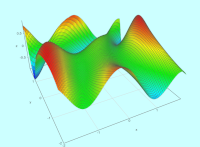


In [ ]:
#Definimos la función
f = lambda X: math.sin(1 / 2 * X[0] ** 2 - 1 / 4 * X[1] ** 2 + 3) * math.cos(
    2 * X[0] + 1 - math.exp(X[1]))